Tommaso Peritore

In [1]:
#matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import matplotlib.colors as mcolors

#numpy
import numpy as np

#glob
import glob 

%config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set_theme(style='darkgrid')

#fit
from scipy.optimize import curve_fit

#variable
variables = ["total_energy","kinetic_energy", "potential_energy", "pressure", "temperature"]
labels = [  "$E^\star/N$",
			 	"$K^\star/N$",
            "$U^\star/N$",
            "$P^\star$", 
            "$T^\star$"]
titles = [  "Total internal energy per particle",
			 	"Kinetic energy per particle",
            "Potential energy per particle",
            "Pressure", 
            "Temperature"]
phase = ["Gas","Liquid","Solid"]
t_values = [1.2,1.1,0.8]
colors = ["lightsteelblue","steelblue","goldenrod","cornflowerblue","cadetblue","darkgoldenrod"]
#colors = ['#d0384e', '#ee6445', '#fece7c', '#d1ed9c', '#97d5a4']

# Exercise 04

## 4.1

The NSL_SIMULATOR code we have provided computes the total (internal) energy per particle, $E/N$, the potential energy per particle, $U/N$, the kinetic energy per particle, $K/N$, and the temperature, $T$.

Include the calculation of the pressure, $P$, inside your Molecular Dynamics code: block averages, progressive average values and progressive uncertainties.

Remember that, via the **virial theorem**, the pressure in a Lennard-Jones system can be estimated by means of:

$$ P = \rho k_B \langle T \rangle + \frac{1}{3V} \left\langle \sum_{i=1}^{N-1} \sum_{j\,(>i)}^N 48\varepsilon \left[ \left(\frac{\sigma}{|\vec{r}_i -\vec{r}_j|}\right)^{12} - \frac{1}{2} \left(\frac{\sigma}{|\vec{r}_i -\vec{r}_j|}\right)^6 \right] \right\rangle $$

## Solution

### Microcanonical ensemble 

In statistical physics, the ensemble is a fundamental concept that represents the group of physical systems that all share the same macroscophic properties, i.e. have the same macrostate, which is characterized by the thermodynamics properties at its equilibrium.

Every ensemble describes a thermodynamical state of the system and one can calculate its thermodynamics properties from the microscopic characteristics of the atoms or molecules. The systems within a microcanonical esemble all share total energy, volume and number of particles. Thus it represents an isolated thermodynamical system where energy is preserved and the number of particles and volume stay constant. In such a scenario, all microstates of the system (i.e. a single point in the phase space) is equally likely to be observed because the energy, matter or work is not exchanged with the outside.

This property comes from the fact a thermodynamical system tends to distribute itself uniformly among its possible microstates, that is those compatible with the conditions of energy and volume. In other words, the system explores all possible microstates within the conditions of the ensemble, and will find itself in one of these configurations with probability proportional to the number of microstates that correspond to that configuration.

Since the exact knowledge of the thermodynamical properties requires to know the precise configuration in the phase space, this is not generally possible to obtain. However, in a simulation one can start from the microscopical properties (temperature, volume, density, etc.) and derive an estimation of microscopical properties (particles position, velocities, etc.) amd then let those evolve.

### Verlet's algorithm

Verlet's algorithm is a numerical method used in Molecular Dynamics to calculate the evolution of particles in a system. It makes use of the particles position and velocity at two different istances of time, allowing it to calculate acceleration and thus make a prediction of future position. Exploiting Taylor expansion in $t+\delta t$ and $t-\delta t$, we obtain 
$$ \vec{r}(t+\delta t) \cong 2\vec{r}(t) - \vec{r}(t-\delta t) + \delta t^2 \vec{a}(t)$$
Thus the algorithm needs information about previous position. This is tackled in the program either by having the system restart from a previous configuration of positions and velocities, or by having the velocities be initialized using Maxwell-Boltzmann distribution and positions be initialized in a configuration of a crystal, provided in `./_INPUT/CONFIG/config.in`.

This algorithm presents a set of properties that make it particularly useful in our scenario:
- it is time-reversible, i.e. forward or backward direction in time are undistinguishable, and will produce the same outputs during the simulation
- it preserves energy, i.e. the total internal energy, kinetic plus potential remain constant.

However it also has some disadvantages:
- it could be influenced by particles being too close, making acceleration diverge and thus a very unstable simulation
- too complex potential interactions are not compatible with this algorithm
- it does not take into account the possibility of energy dissipation, for example due to friction, which could be important for some simulations.

### Periodic Boundary Conditions

Periodic buondary conditions (PBC) is a tecnique widely used when simulatinf physical systems. They allow a system to be considered a periodic box, where the border conditions are imposed assuming that identical boxes repeat in all directions indefinitely.

Molecular Dynamics makes wide use of PBC, for the general goal of a simulation, which would be to describe the evolution of the positions and velocities of the single particles, would require to simulate a huge number of particles and would end up being computationally challenging. However, with PBC, one can simply limit its attention to a small part of the system, a box of defined dimension, and the one adjacent to simulate the interaction with all other particles of the system.

### General comment on exercise

As with this and all future exercises that require the NSL_SIMULATOR code provided, the approach I took was to make a copy of the code inside the subdiretory of the exercise and modify according to the needs of the specific exercise. 
<br> Here in this exercise, the directory for both 4.1 and 4.2 is `./4.1` and is organized with main source code inside `_SOURCE`, input files `_INPUT` and results of the simulations are organized depending on the phase in `Gas`, `Liquid` and `Solid`.

The input file allow us to define the parameters of the simulation. Here is an example of one
>SIMULATION_TYPE $\quad\;\;$ 0 3 0
><br>TEMP $\qquad\qquad\qquad\quad\,$ 1.54
><br>RESTART $\qquad\qquad\qquad\quad$ 0
><br>NPART $\qquad\qquad\qquad\quad$ 108
><br>RHO $\qquad\qquad\qquad\qquad\;$ 1.1
><br>R_CUT $\qquad\qquad\qquad\quad\;$ 2.2
><br>DELTA $\qquad\qquad\qquad$ 0.0005	
><br>NBLOCKS $\qquad\qquad\qquad$ 100
><br>NSTEPS $\qquad\qquad\qquad$ 1000
><br>
><br>ENDINPUT

Where the parameters are
- SIMULATION_TYPE: type of simulation, here with $0$ we run a LJ MOLECULAR DYNAMICS (NVE) SIMULATION; phase type (Gas, Liquid, Solid) and a boolean for equilibration. 
- TEMP: temperature to be initialized at the beginning of simulation. This allows also to initialize the particles velocities making use of Maxwell-Boltzmann distribution.
- RESTART: boolean to tell the system whether to restart the simulation from a previously saved configuration. 
- NPART: number of particles, here we have it set to $108$.
- RHO: density of the system. From here the volume and dimensions of the box are extracted.
- R_CUT: cutoff radius.
- DELTA: Verlet's algorithm step size.
- NBLOCKS: number of blocks.
- NSTEPS: number of steps per block.


### Pressure implementation

The implementation of the calculation of the pressure $P$ of our system required to find the formula in reduced units. This simply means to chose a convenient unit of energy, length and mass and then express quantities such as temperature, density and pressure in terms of these units.
<br> In a Lennard-Jones system it is fitting to chose:
- unit of length $\sigma$
- unit of energy $\varepsilon$
- unit of mass $m$

and from here all other units follow. The main importance of introducing reduced units is the law of corresponding states, where in reduced units infinitely many combinations of $\rho$, $T$ and $\varepsilon$ all correspond to the same state. We can then define the following reduced units and conversions:
- distance $r^\star = r / \sigma$
- Lennard-Jones potential $\upsilon^\star = 4 \left[ \left(1/r^\star\right)^{12} - \left(1/r^\star\right)^{6}\right]$
- time $t^\star = t/\sigma\sqrt{m/\varepsilon}$
- temperature $T^\star = k_B T /\varepsilon$
- potential energy $V^\star = V/\varepsilon$
- pressure $P^\star = P \sigma^3/\varepsilon$
- density $\rho^\star = \rho\sigma^3$

Utilizing these conversions we derived the formula for pressure in reduced units
$$ P^\star = \rho^\star T^\star + \frac{48}{3V^\star} \left\langle \sum_{i=1}^{N-1} \sum_{j\,(>i)}^N \left[ \left(r^\star_{ij}\right)^{-12} - \left(r^\star_{ij}\right)^{-6} \right] \right\rangle $$

This formula was introduced into the method of our system class `void System :: measure ()` and needed nothing more to be used.

## 4.2

By means of your upgraded code, perform MD simulations via a Lennard-Jones model of Argon ($\sigma = 0.34$ nm, $\varepsilon/k_B = 120$ K, $m=39.948$ amu) in the following conditions:
1. solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
2. liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
3. gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

and show in pictures the obtained progressive average values and uncertainties as a functions of the increasing number of blocks for the total (internal) energy per particle, $E/N$, the potential energy per particle, $U/N$, the kinetic energy per particle, $K/N$, the temperature, $T$, and the pressure, $P$, in reduced units!

Warning: equilibration is needed.

By monitoring the temperature, $T$, during the first time steps of the simulation, you will observe that at the beginning, starting from a perfect crystalline configuration, $T$ will not conserve its value. Can you understand and explain this behaviour?

Explore and find the starting value of $T$ needed to stabilize, after a certain number of time steps (equilibration time), the average value of $T$ on the desired $T^\star$. Perform your solid/liquid/gas phase MD simulations by re-starting them after such equilibration time.

## Solution

### Equilibration process

To accomodate the process of equilibration into the given code some tweaks were necessary.
The first modification tackled the necessity to pass from command line the directory path to the input file, i.e. the input.in path has to be given upon execution.

This allowed me to write up a bash script, `./4.1/_INPUT/equilibration_routine.sh` that taking as input a choice of phase (Solid, Liquid or Gas) started the equilibration process. Since I wanted to be able to access data of evolving temperature for each instance of the simulation, the bash script cycles through values of starting temperature and executes the simulation with an input file where the temperature has been modified accordingly. 

In practice, a range of temperatures for each phase has been calibrated to cover the proximity of the starting temperature which then equilibrates at the desired temperature for the actual simulation. Within that range, for every value of temperature, the bash script modifies the `input_equilibration.in` input file and then executes the `simulator.exe` with that input file.

The input file format has been also modified slightly so that the first line `SIMULATION_TYPE` also contains an integer for the phase (3 for Solid, 2 for Liquid and 1 for Gas) and a bool to indicate whether the simulation was done for equilibration. If this indicator were true, the execution only makes measurements of temperature and prints them in output files in `./4.1/<phase>/EQUILIBRATION`.

Here below I graphed the equilibration steps for all phases.

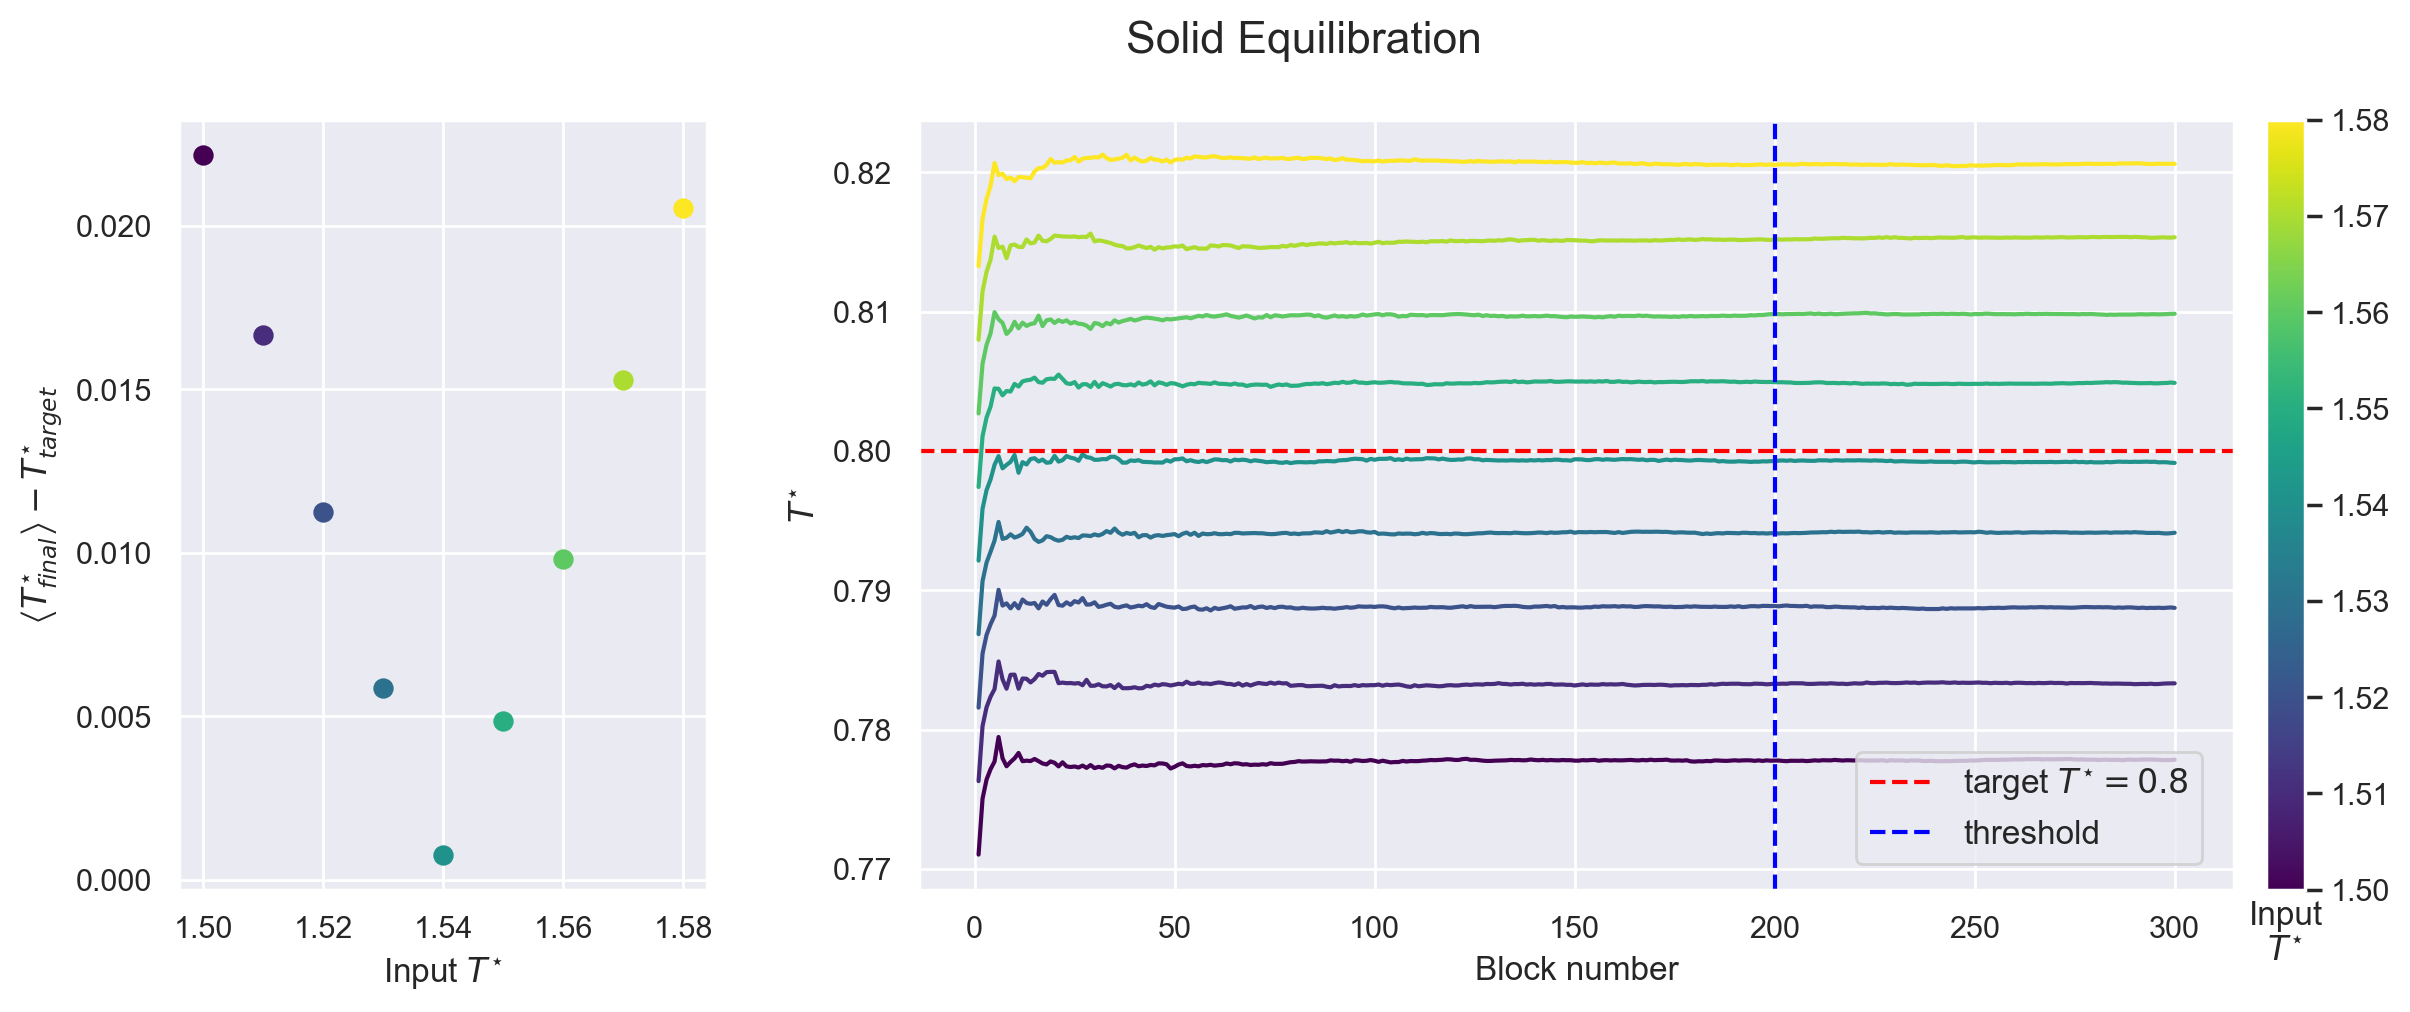

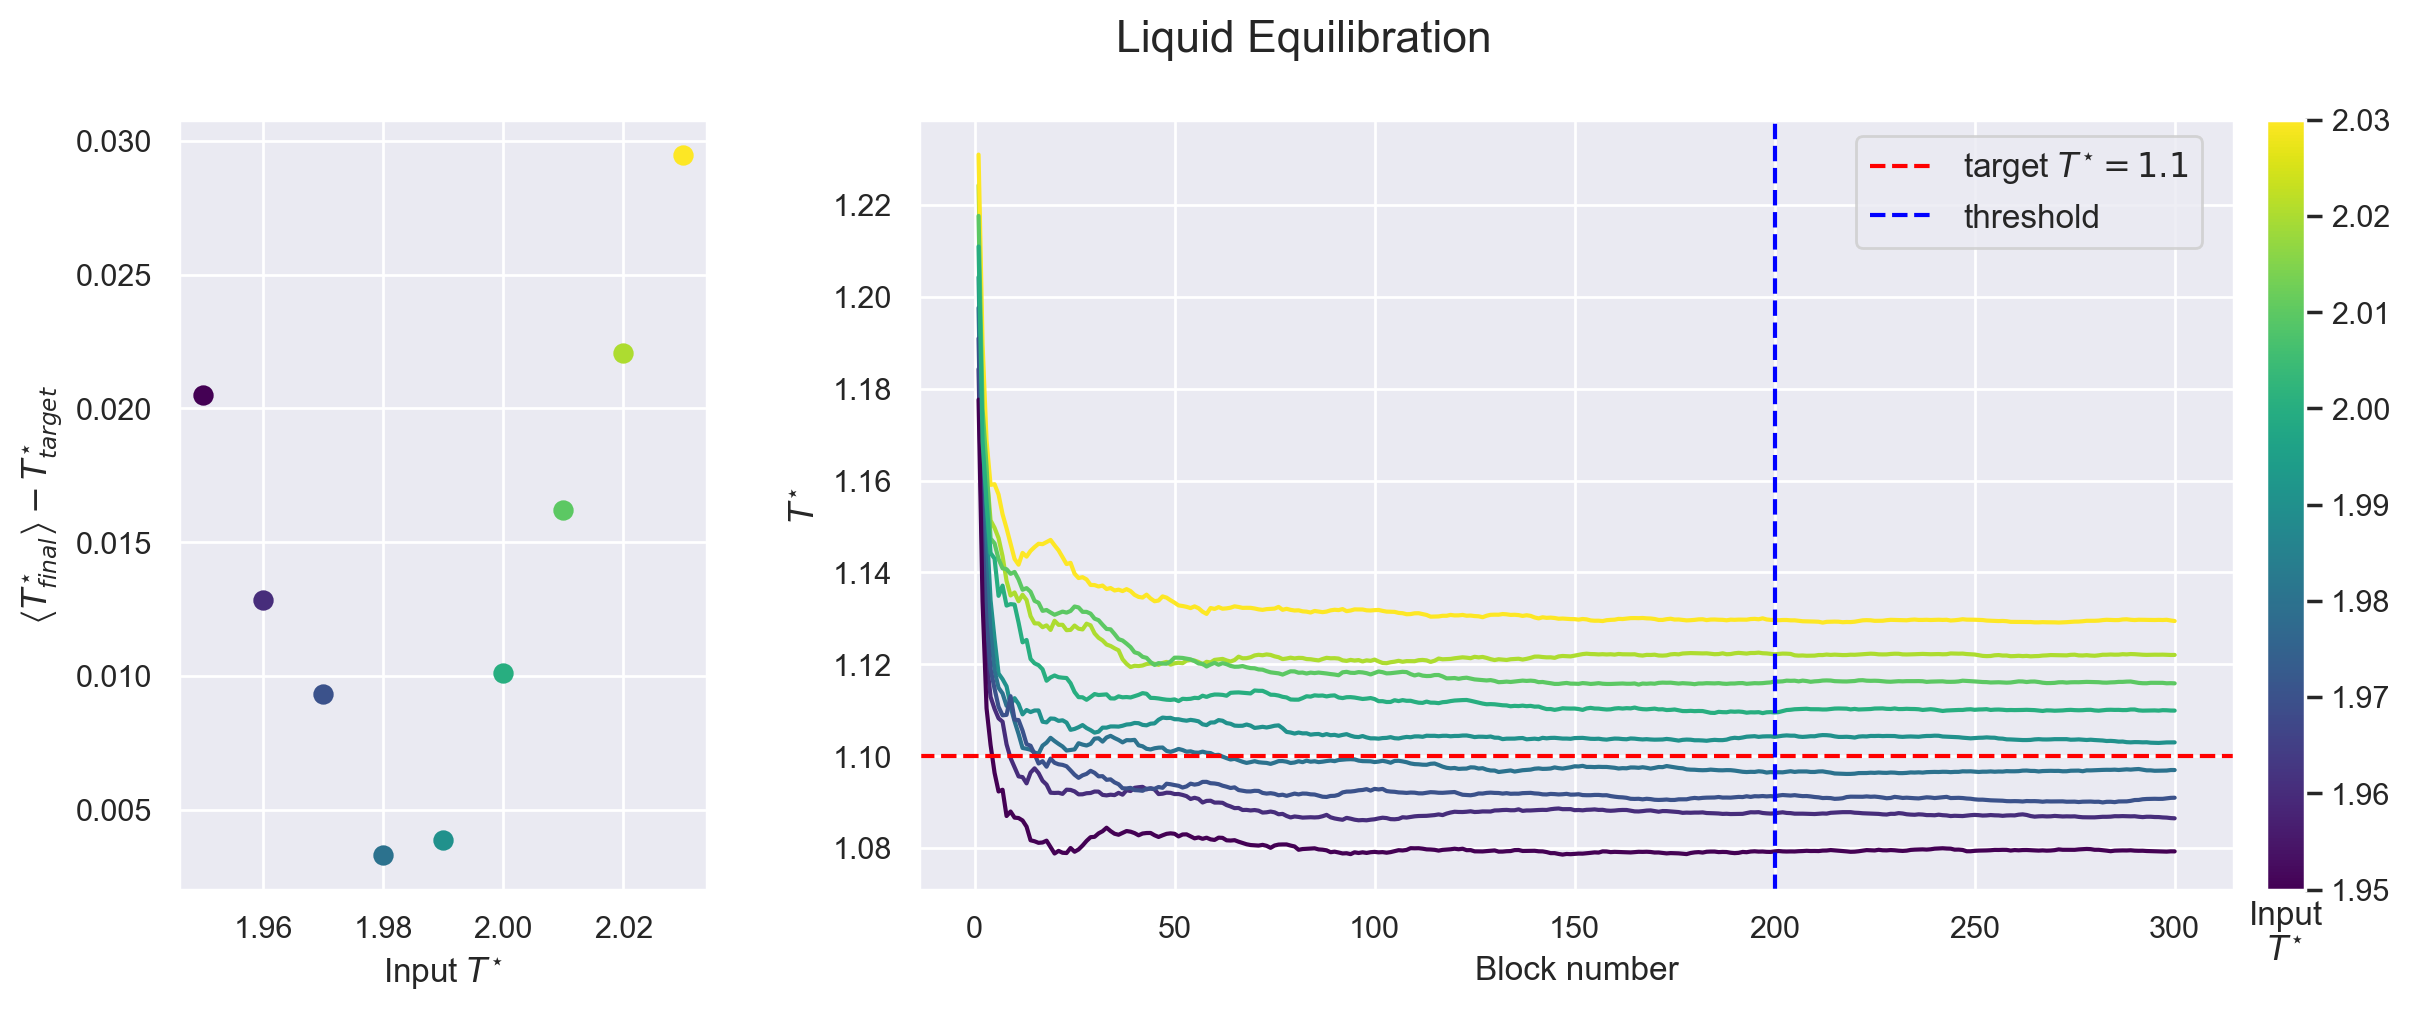

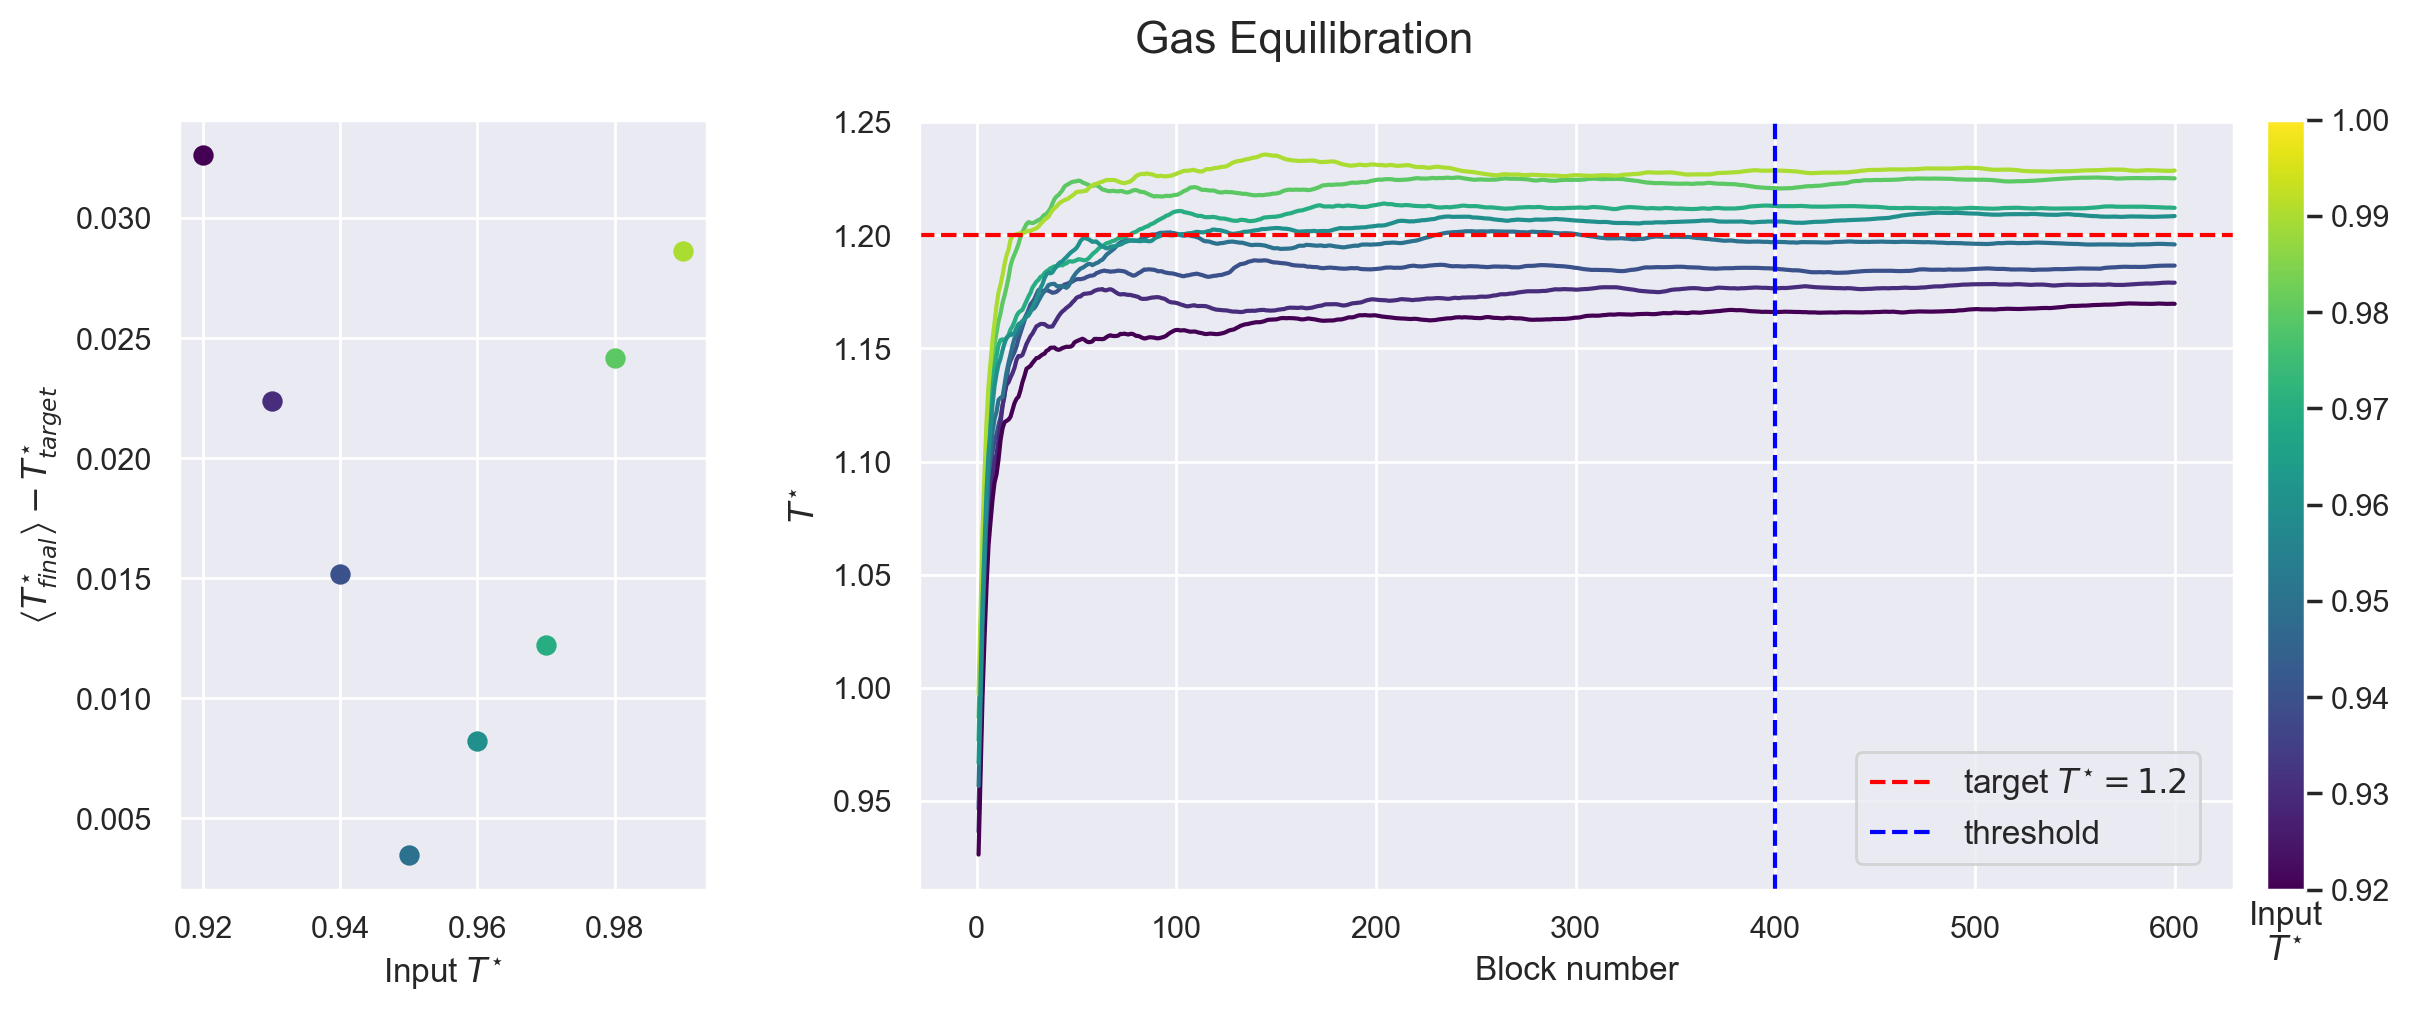

In [2]:
# Define a function to create equilibration plots for a given phase
def plot_equilibration(phase_name, vmin, vmax, target_temp, threshold, xlabel_offset, ylabel_offset):
    # Get a list of all the files that match the pattern in the specified phase directory
    file_list = glob.glob(f"./4.1/{phase_name}/Equilibration/*_temperature.dat")

    # Create subplots with adjusted sizes
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 3]})
    
    # Define color map
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.ScalarMappable(norm=norm, cmap='viridis')

    # Loop over the files and plot data
    for file in file_list:
        temp = np.loadtxt(file, usecols=(0, 2))
        # Extract the input temperature from the filename
        input_temp = float(file.split("/")[-1].replace("_temperature.dat", ""))
        color = cmap.to_rgba(input_temp)  # Get color from the colormap
        
        # Plot scatter plot
        mean_deviation = abs(np.mean((temp[threshold:, 1] - target_temp)[1:]))
        ax1.scatter(input_temp, mean_deviation, color=color, s=40)
        ax2.plot(temp[:, 0], temp[:, 1], color=color)

    # Set labels and titles
    ax1.set_ylabel(r'$\left\langleT^{\star}_{final}\right\rangle-T^{\star}_{target}$', fontsize=12)
    ax1.set_xlabel('Input $T^{\star}$', fontsize=12)
    
	 # Create a horizontal color bar at the bottom
    cbar = plt.colorbar(cmap, ax=ax2, pad=0.02)
    
    # Set the color bar label with multiple lines
    cbar.ax.set_xlabel("Input\n$T^{\star}$", fontsize=12, ha='center')  # Use 'ha' for horizontal alignment

    ax2.set_ylabel('$T^{\star}$', fontsize=12)
    ax2.set_xlabel('Block number', fontsize=12)

    # Set horizontal and vertical lines for target and threshold
    target_line_label = f'target $T^{{\\star}} = {target_temp}$'
    ax2.axhline(target_temp, color='red', linestyle='--', label=target_line_label)
    ax2.axvline(threshold, color='blue', linestyle='--', label='threshold')

    # Set legend and title
    ax2.legend(bbox_to_anchor=(xlabel_offset, ylabel_offset), fontsize=12)
    fig.suptitle(f'{phase_name} Equilibration', fontsize=16)
    
    plt.show()

# Create plots for each phase
plot_equilibration("Solid", vmin=1.50, vmax=1.58, target_temp=0.8, threshold=200, xlabel_offset=0.7, ylabel_offset=0.2)
plot_equilibration("Liquid", vmin=1.95, vmax=2.03, target_temp=1.1, threshold=200, xlabel_offset=0.7, ylabel_offset=1)
plot_equilibration("Gas", vmin=0.92, vmax=1.0, target_temp=1.2, threshold=400, xlabel_offset=0.7, ylabel_offset=0.2)


### Evolution

It is direclty from these graphs that I was able to obtain the necessary information to know how to start the actual simulations: in fact the first thing I did was to locate a block number after which the equilibration temperature curves seemed to be stable enough, plotted on the graphs as the blue vertical line _threshold_. This number varied significantly for gas phase which took a lot longer to equilibrate. Then, by taking the mean deviation of the temperature from the threshold to the end of the simulation, I plotted the difference between this value and the desired temperature, thus formally identify the beginning temperature needed.

Thus the input files for the 3 phases `./<phase>/INPUT/input.in` had to be modified as
1. solid phase: $T^\star = 0.8$, $T^\star_{start} = 1.54$, `equilib_blocks` $=200$
2. liquid phase: $T^\star = 1.1$, $T^\star_{start} = 1.98$, `equilib_blocks` $=200$
3. gas phase: $T^\star = 1.2$, $T^\star_{start} = 0.95$, `equilib_blocks` $=400$

where the last variable is the number of blocks needed for equilibration, after which the measurements on the system will begin to be saved. The cycle in the first steps for equilibration for the actual simulation is implemented in the `NSL_SIMULATOR.cpp`.

Here we show in comparison between phases the data obtained after the equilibration time for total (internal) energy per particle $E/N$, potential energy per particle $U/N$,  kinetic energy per particle $K/N$, temperature $T$, and pressure $P$.

All 3 phases, after equilibration, where run for a total of `_nblocks` $=100$ blocks and a size of each block `_nsteps` $=1000$. For details on how to run the equilibration and the simulation, consult the `./ReadMe.md`. 

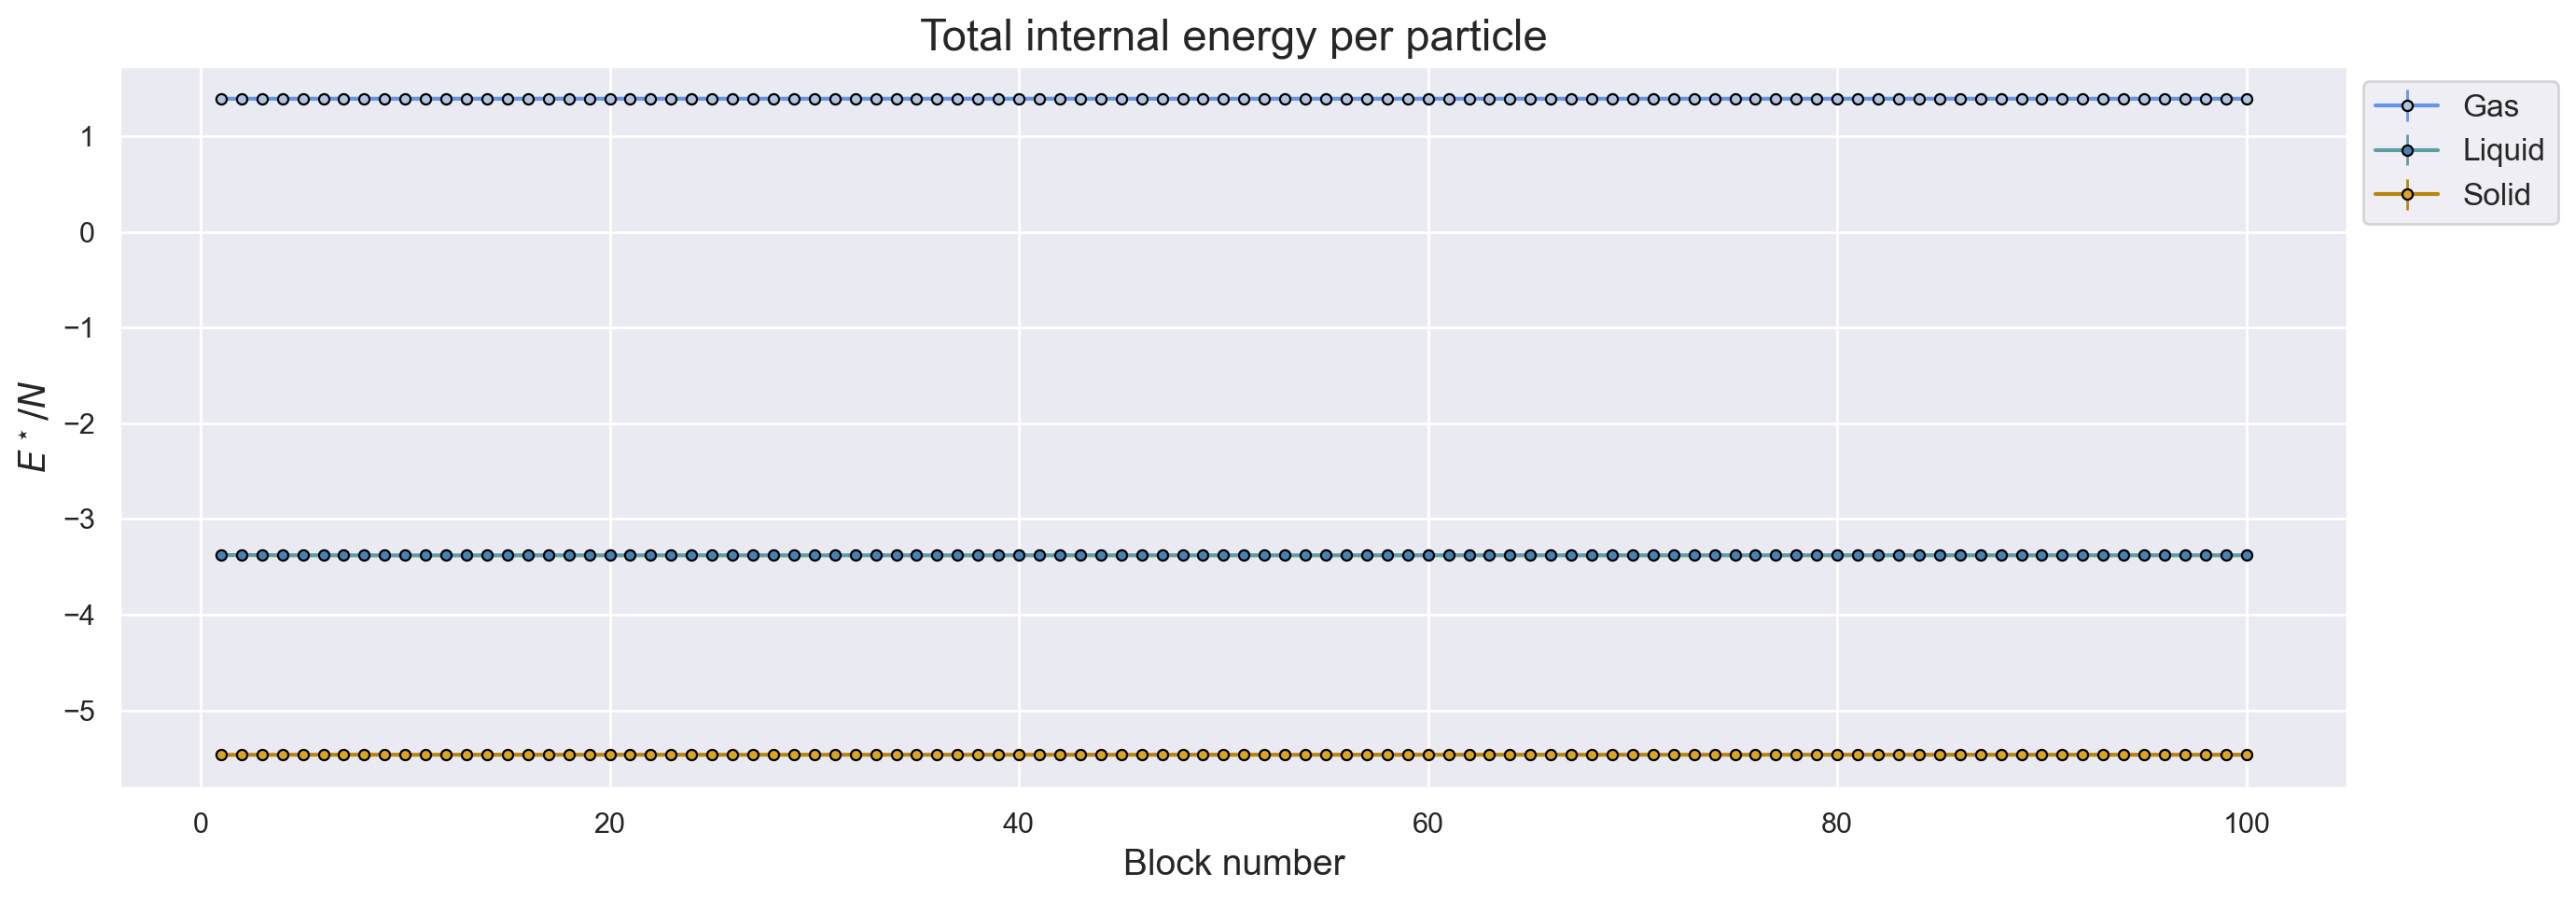

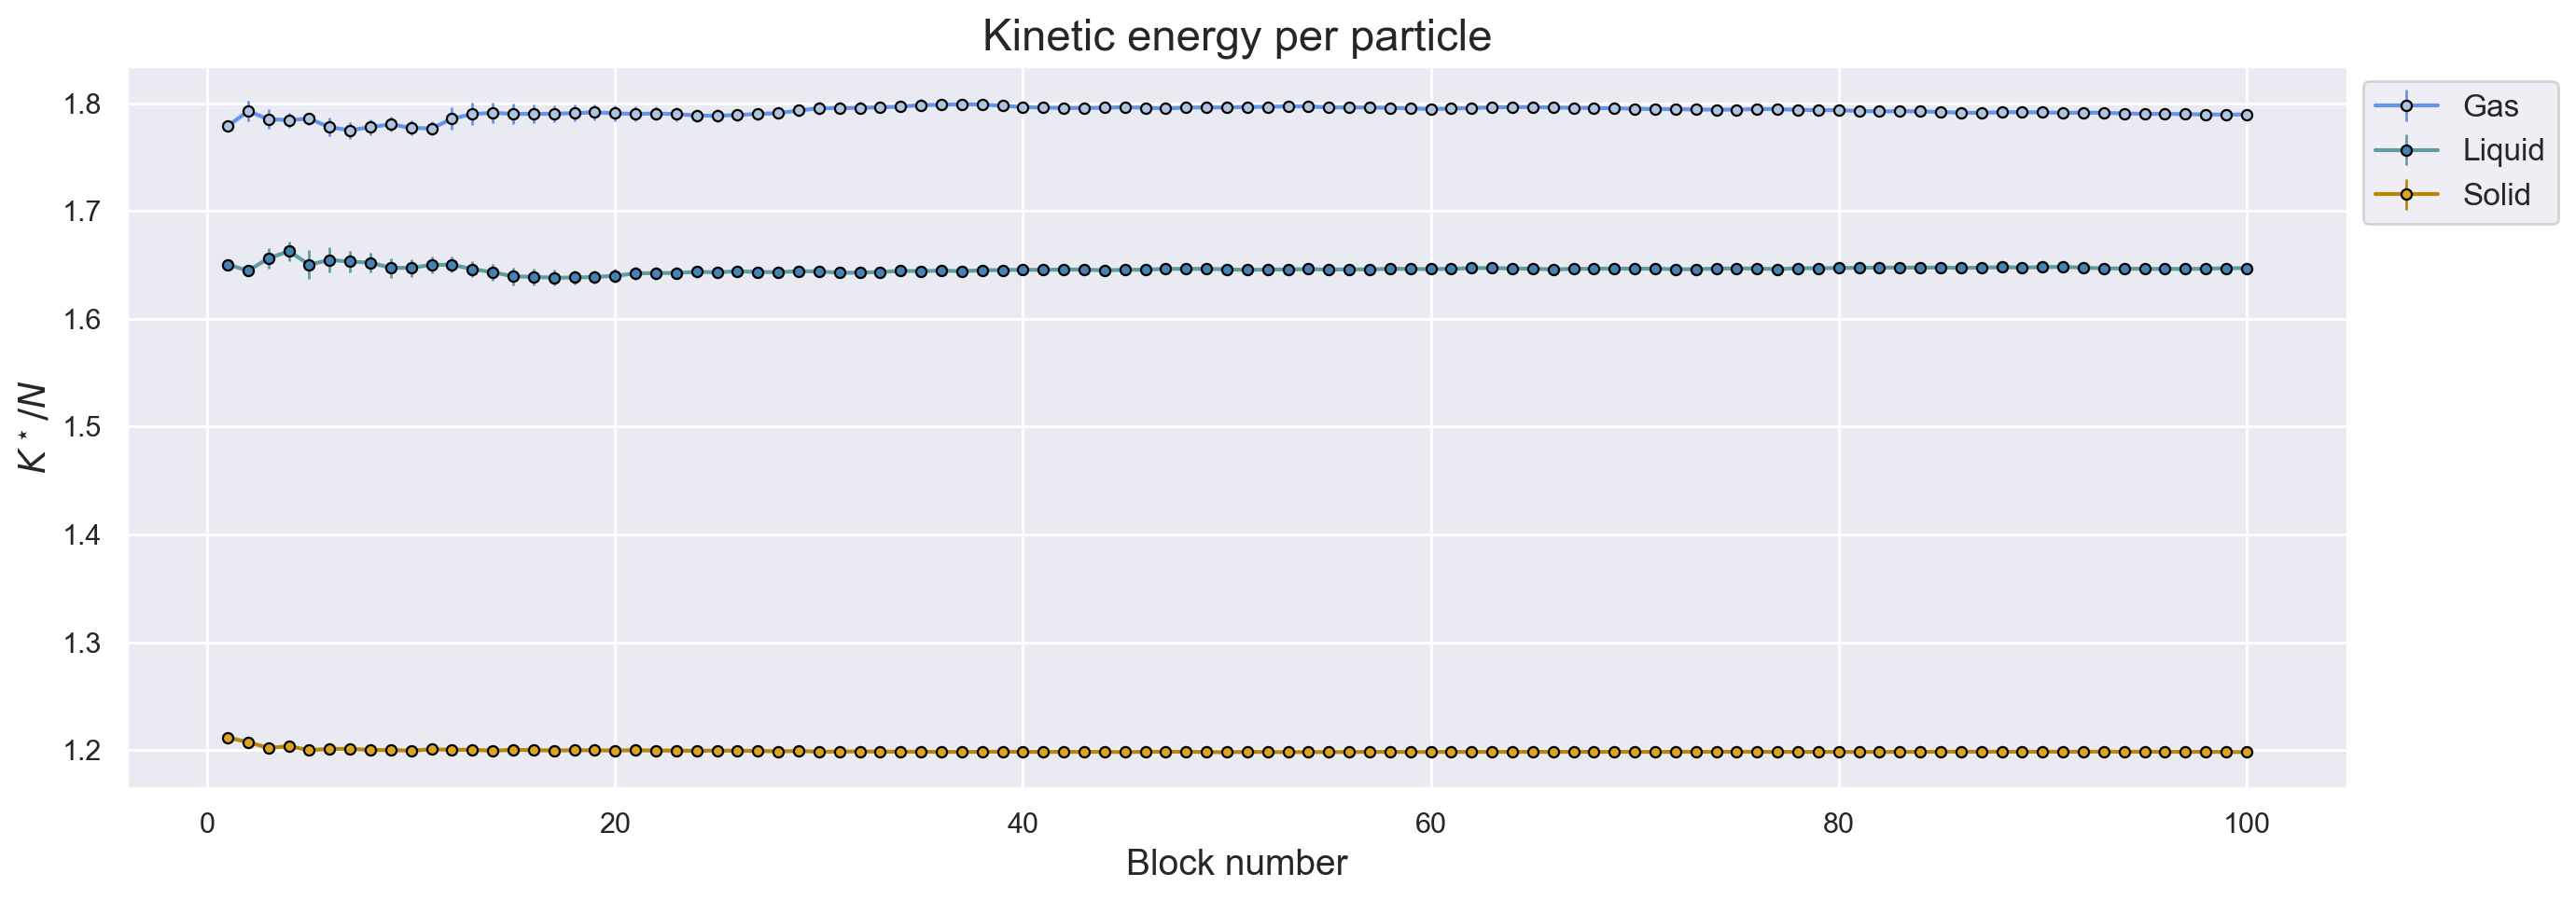

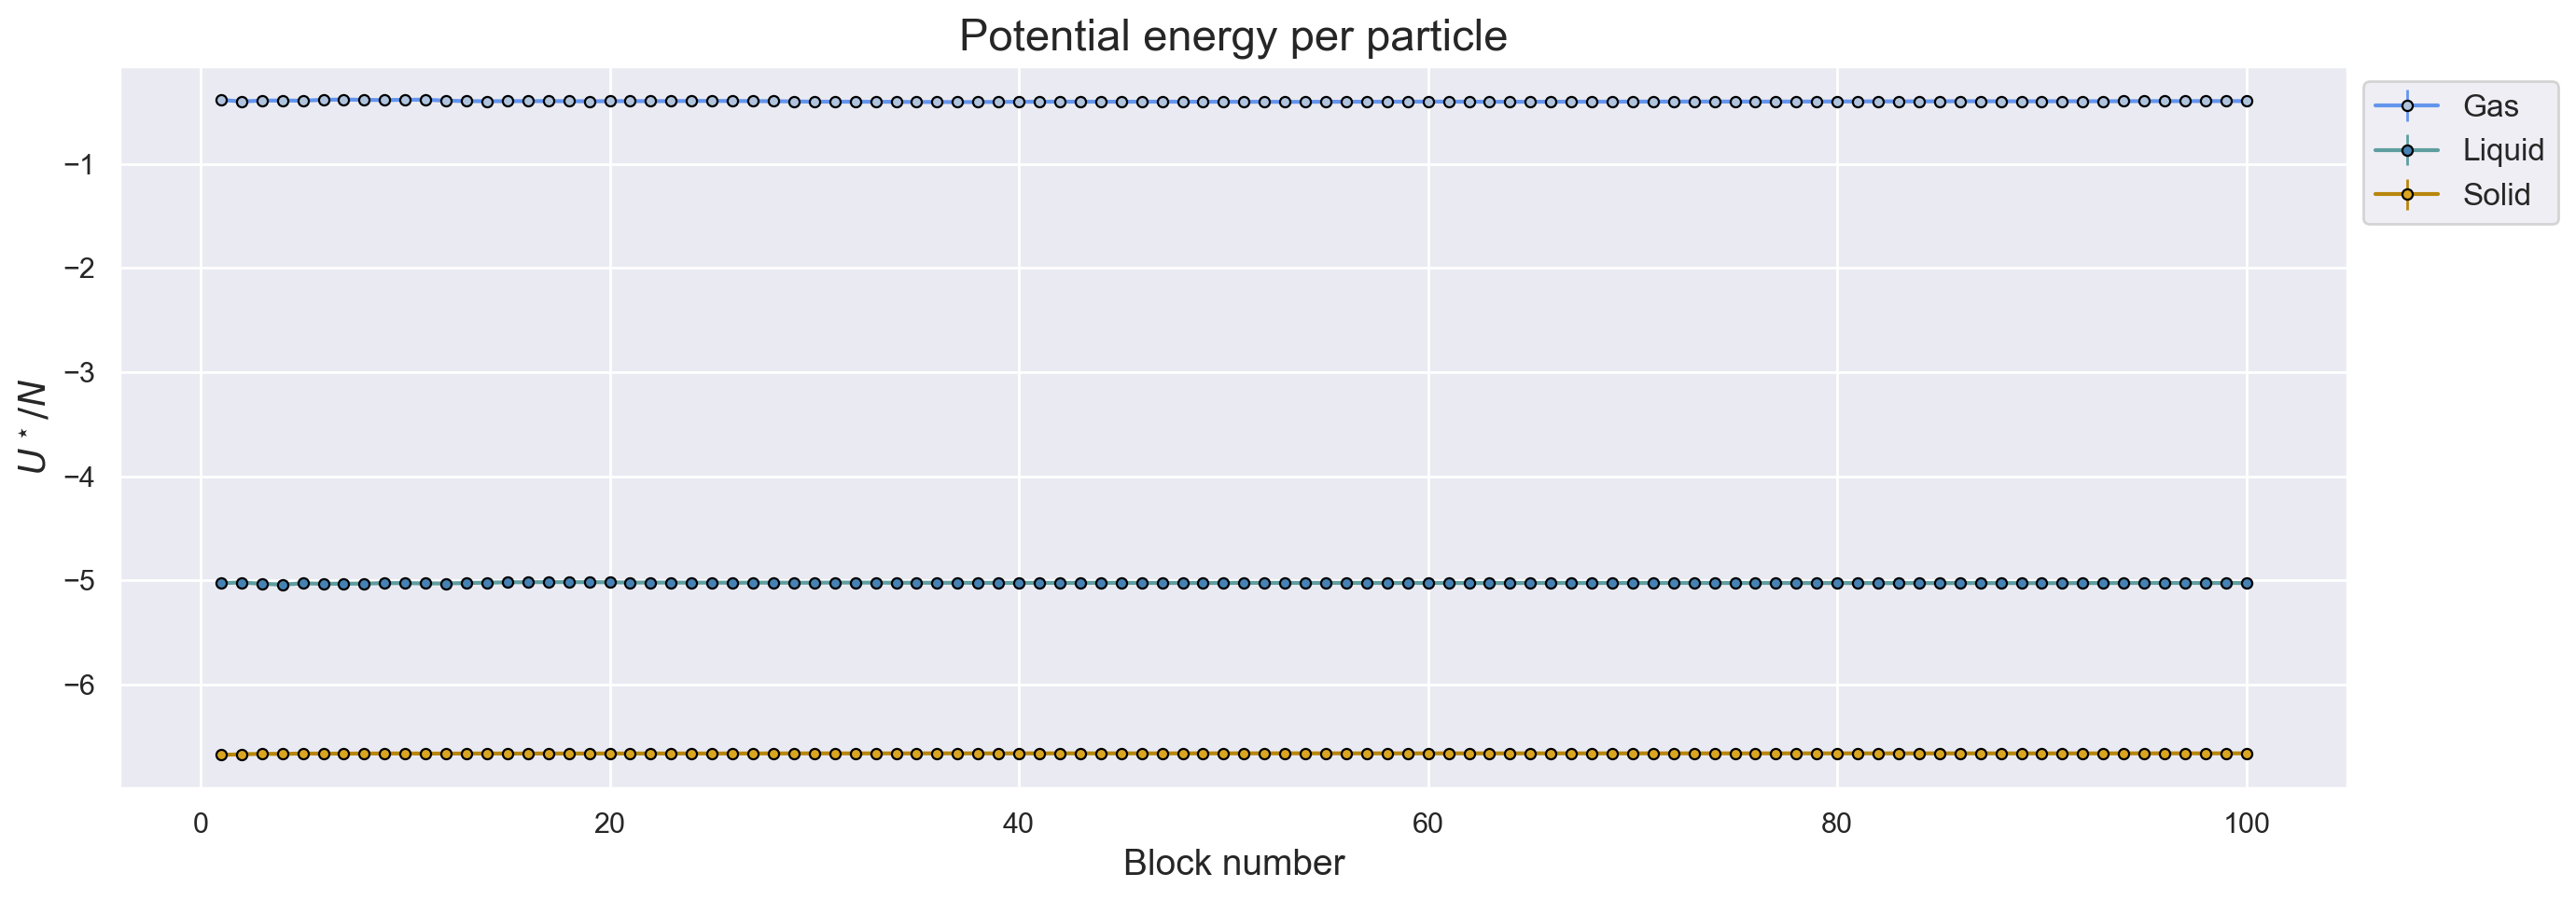

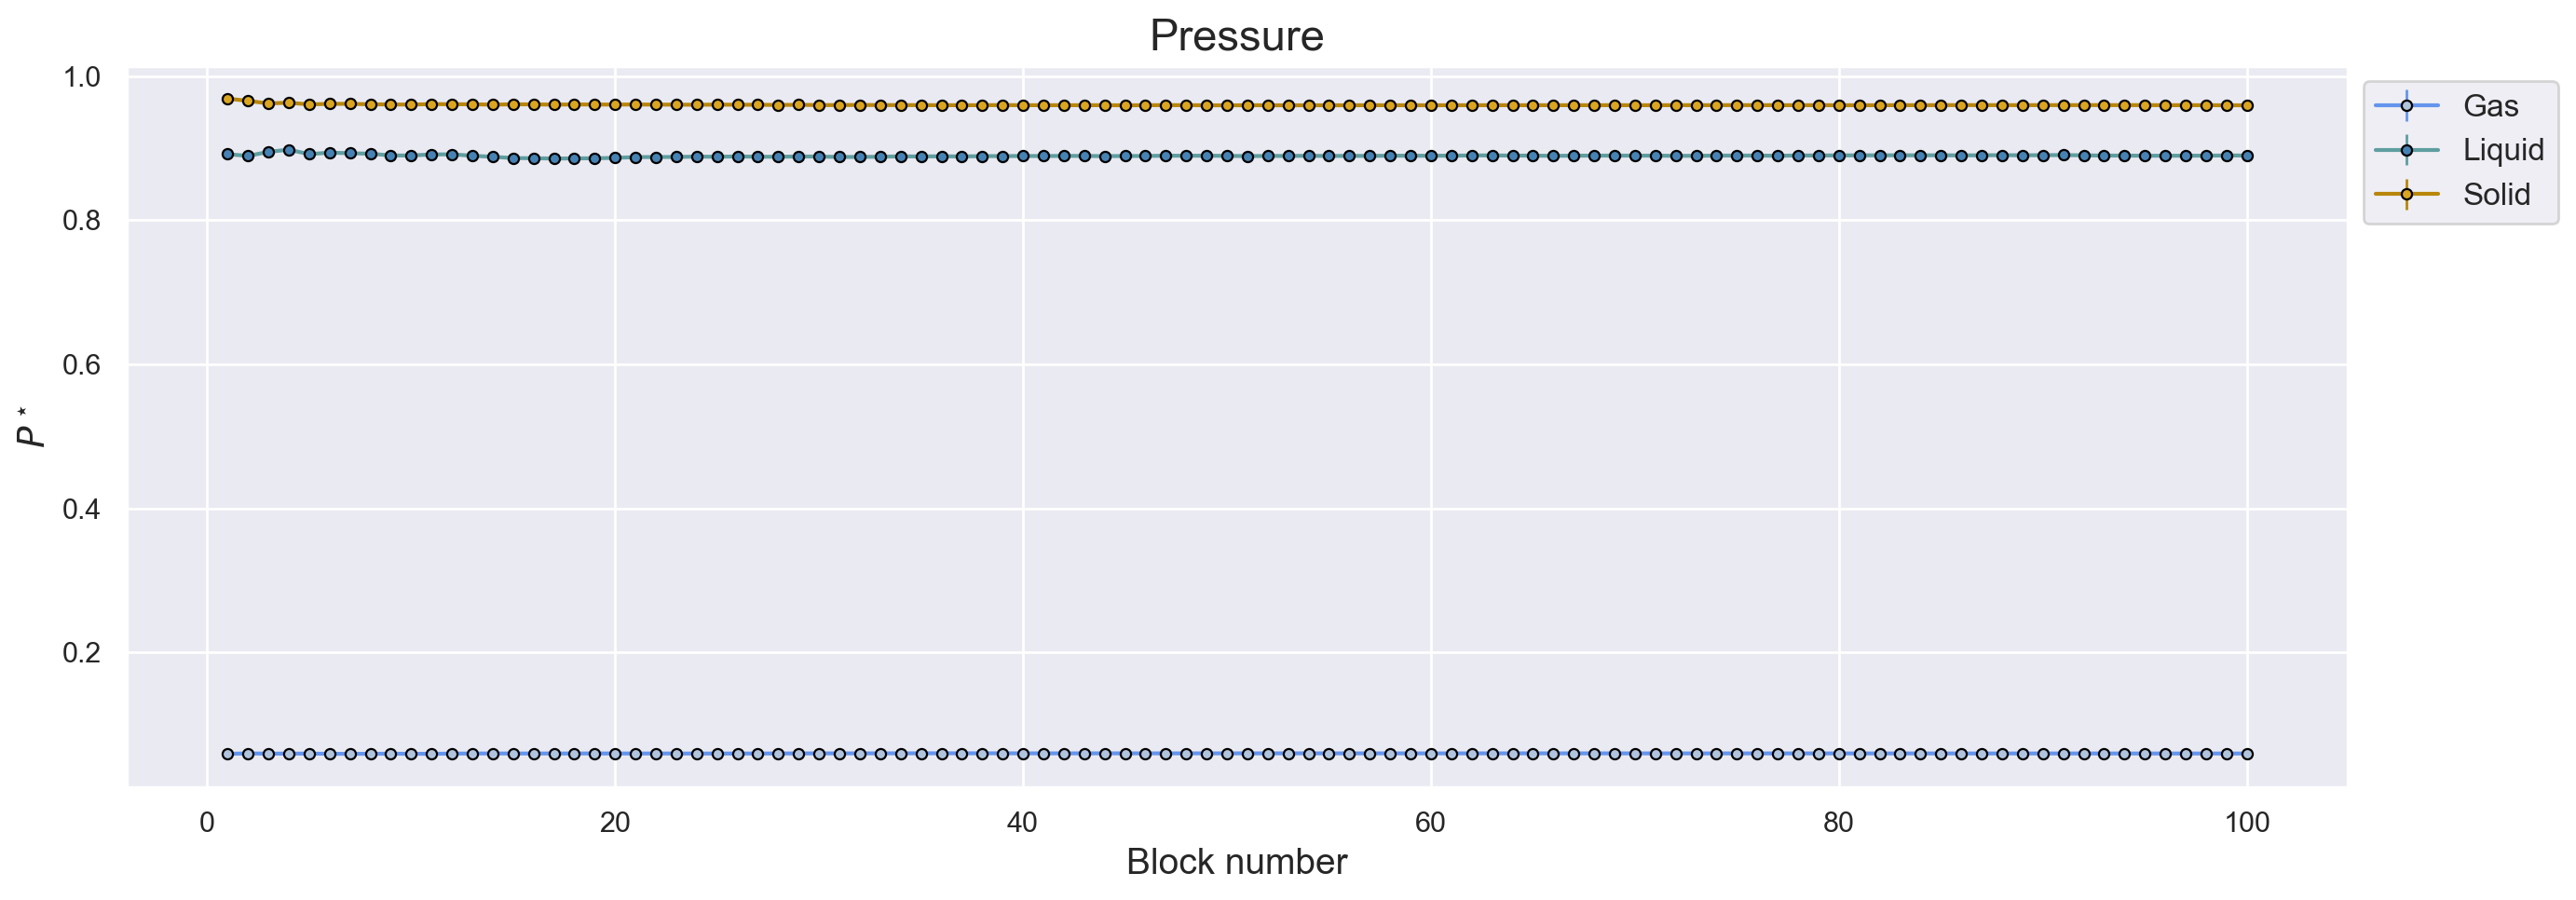

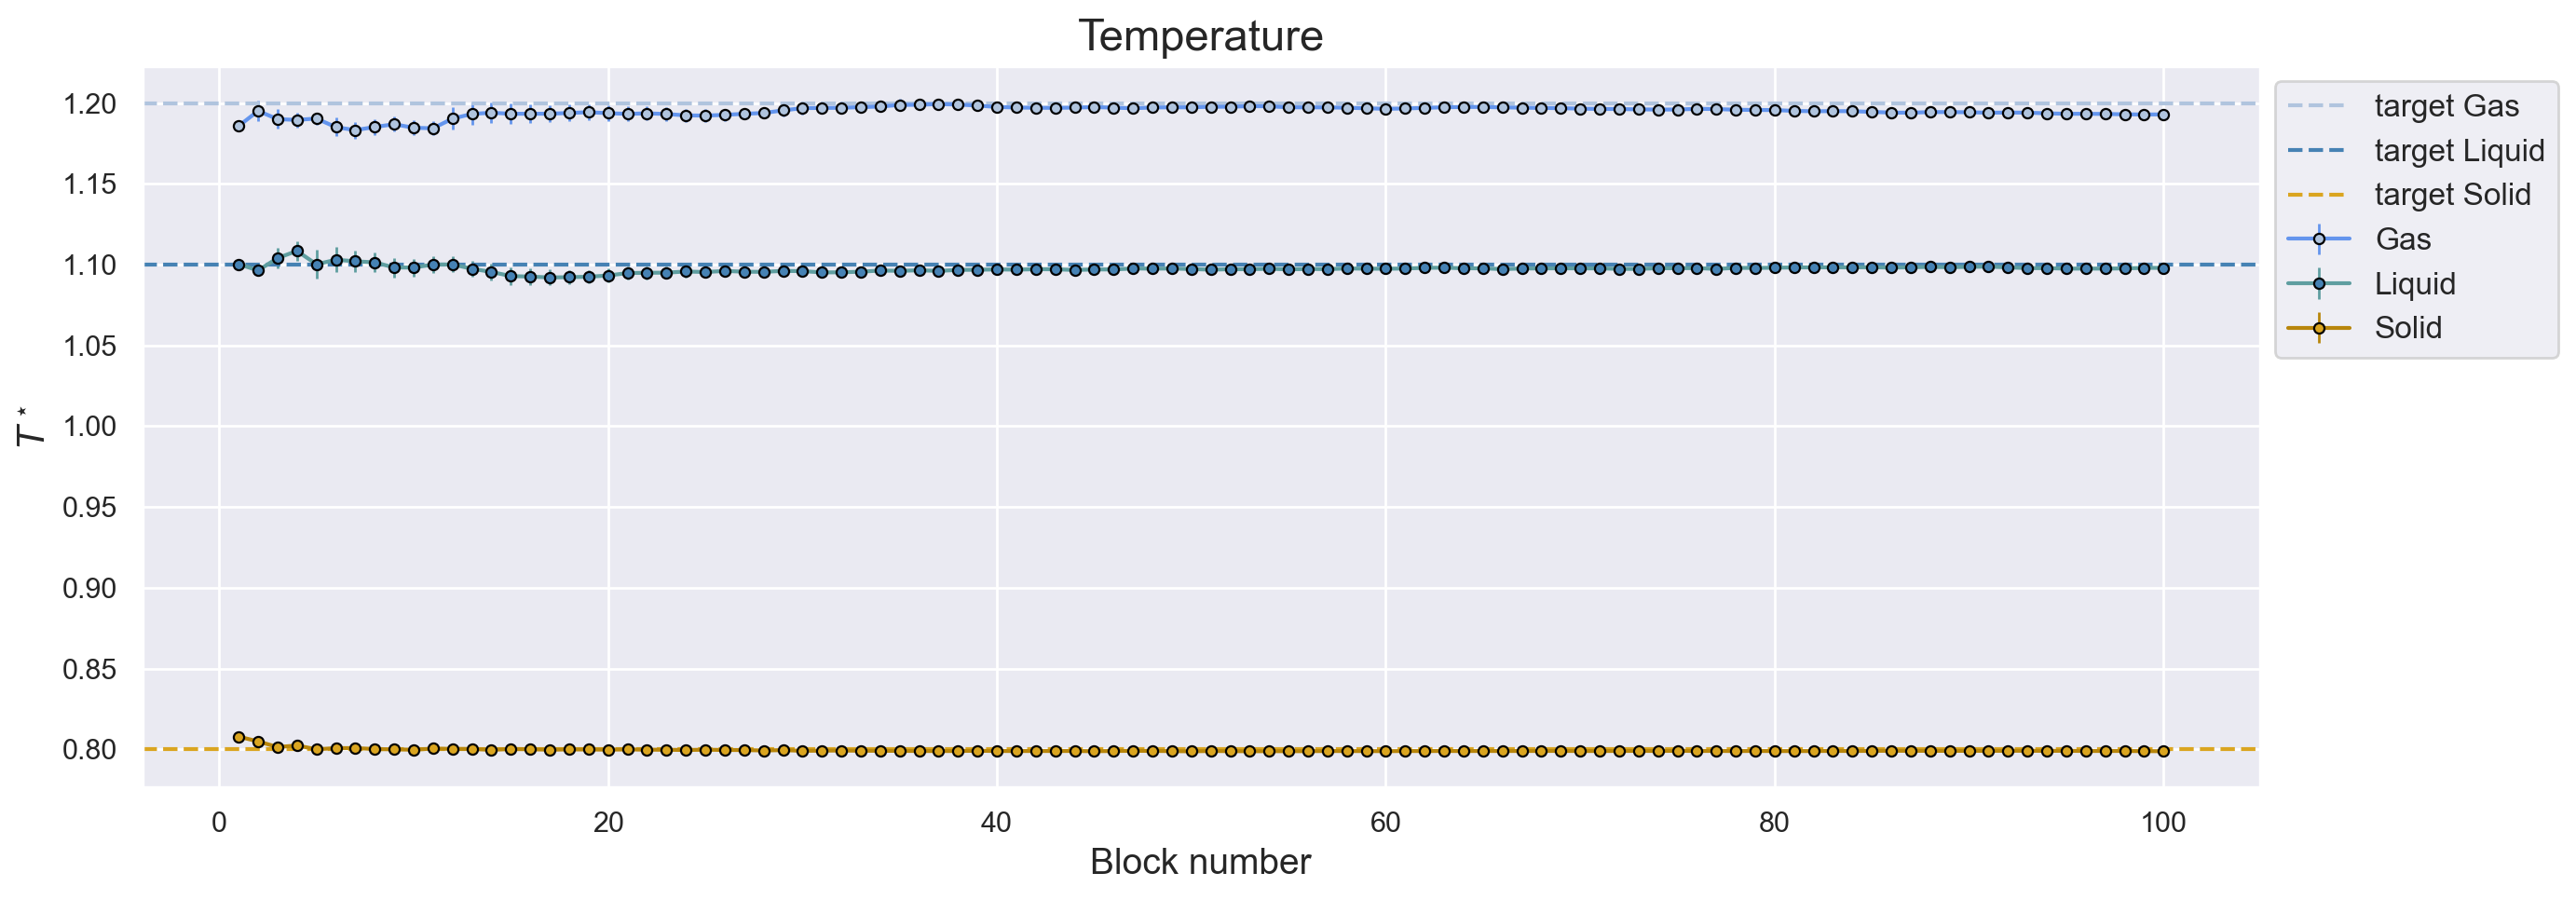

In [4]:
# simulation data
for i in range(0, 5):
	fig = plt.figure(figsize=((14,5)))
	for j in range(0, 3):
		temp, progressive_sum, progressive_error = np.loadtxt("./4.1/" + phase[j] + "/OUTPUT/" + variables[i] + ".dat", unpack=True, usecols=(0, 2, 3))
		plt.errorbar(temp, progressive_sum, yerr=progressive_error, marker='o',ms=4,mec='black',mfc=colors[j],mew=0.8,label=phase[j], color=colors[j+3],lw=1.5,elinewidth=1)
		if(i == 4):            
			plt.axhline(t_values[j], c=colors[j], ls='--', label="target " + phase[j])
	plt.xlabel('Block number', fontsize=14)
	plt.ylabel(labels[i], fontsize=14)
	plt.title(titles[i], fontsize=17)
	plt.legend(bbox_to_anchor =(1, 1),fontsize=12)
	plt.grid(True)
	plt.tight_layout()
	plt.show()

### General comments on results

The output data that the simulation collected convalidates the code since we expected the total energy to be conserved, as it should in a microcanonical ensemble, and it is exactly what can be seen in the above graphs for all 3 phases, where the total energy, as well as the potential, can be seen not varying significantly.
<br> A little more fluctuations can be noticed in the temperature graphs, especially in the liquid phase and even more in the gas phase. However something to point out is the close resemblance of temperature and kinetic energy fluctuations, which is expected given they are proportional to one another.